In [1]:
# change directory, check the correct path: 
from os import chdir
chdir('/Users/lananhnguyen/Desktop/thesis/thesis_code')

# Import my package:
import main.packages.mine_generic as mine_g
import main.packages.mine_specific as mine_s

# Other packages:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose


# 1. Benchmark models:

## Load and clean data:

Data length: 331 rows from 75.1 to 126.7
0           hicp_all
date                
1996-01-31      75.1
1996-02-29      75.6
1996-03-31      75.7
1996-04-30      75.6
1996-05-31      75.7


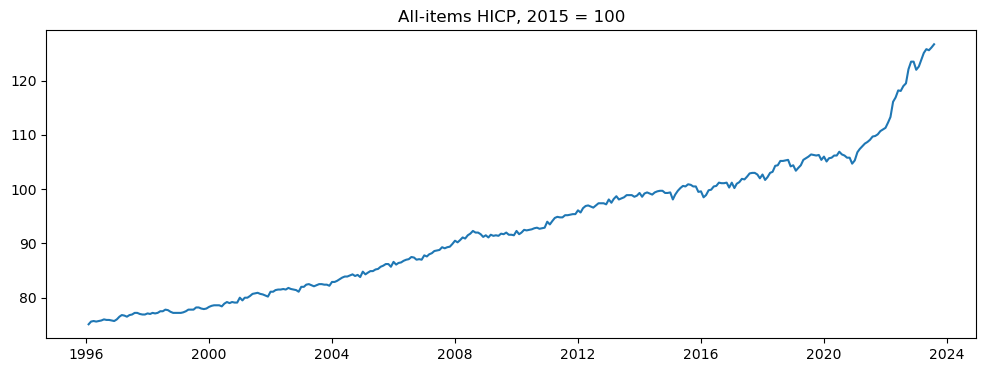

In [6]:
headline = mine_g.load_excel('data/hicp_all.xlsx', 'hicp_all')
mine_g.data_viz(headline, title= 'All-items HICP, 2015 = 100')

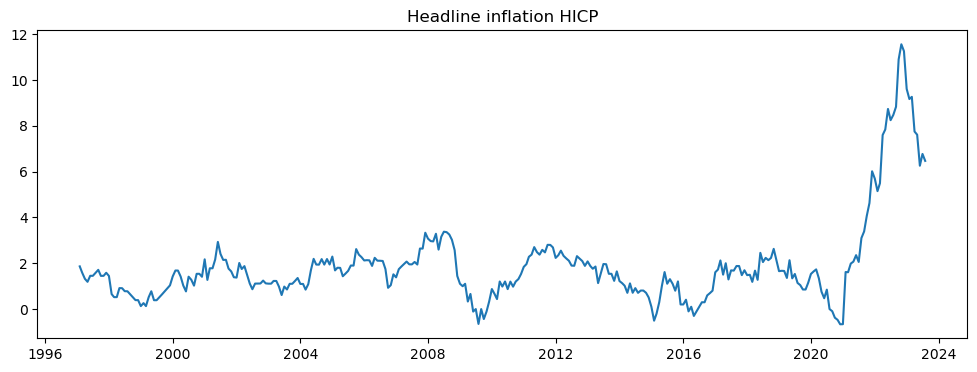

In [7]:
head_inf = mine_g.transform_yoy_rate(headline)
mine_g.data_viz(head_inf, title= 'Headline inflation HICP')
head_inf.to_csv('data/preprocessed/head_inflation.csv')

## Time series analysis:

- Test for autocorrelation
- ADF test for stationarity
- ACF and PACF plots
- Seasonal decomposition and plot residuals.
- ACF and PACF plot for differencing 1.

In [8]:

autocorr_values = head_inf.autocorr()
print("Autocorrelation:", autocorr_values) #large autocorr -> can be AR model

Autocorrelation: 0.9721133972549411


In [9]:
mine_g.dftest(head_inf)

Test Statistic        -3.198781
p-value                0.020055
Lags Used             14.000000
Observations Used    304.000000
dtype: float64
Time series is stationary!


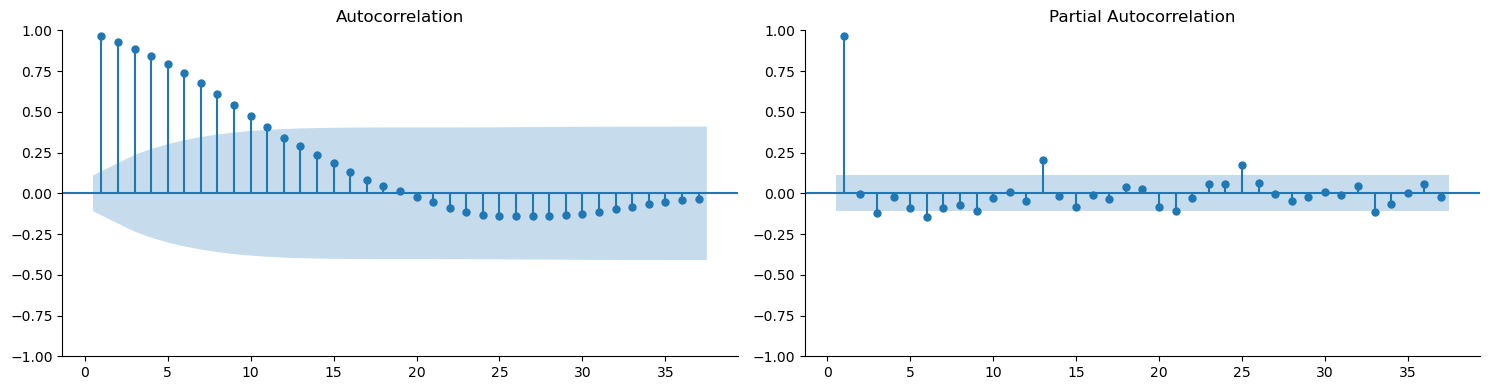

In [10]:
mine_g.plots_acf_pacf(head_inf, lags = 37)

ACF is initially large, then decays gradually to zero, then switch to be negative.
p = 1, 13, 25, 37,... have large PACF -> annual seasonality.

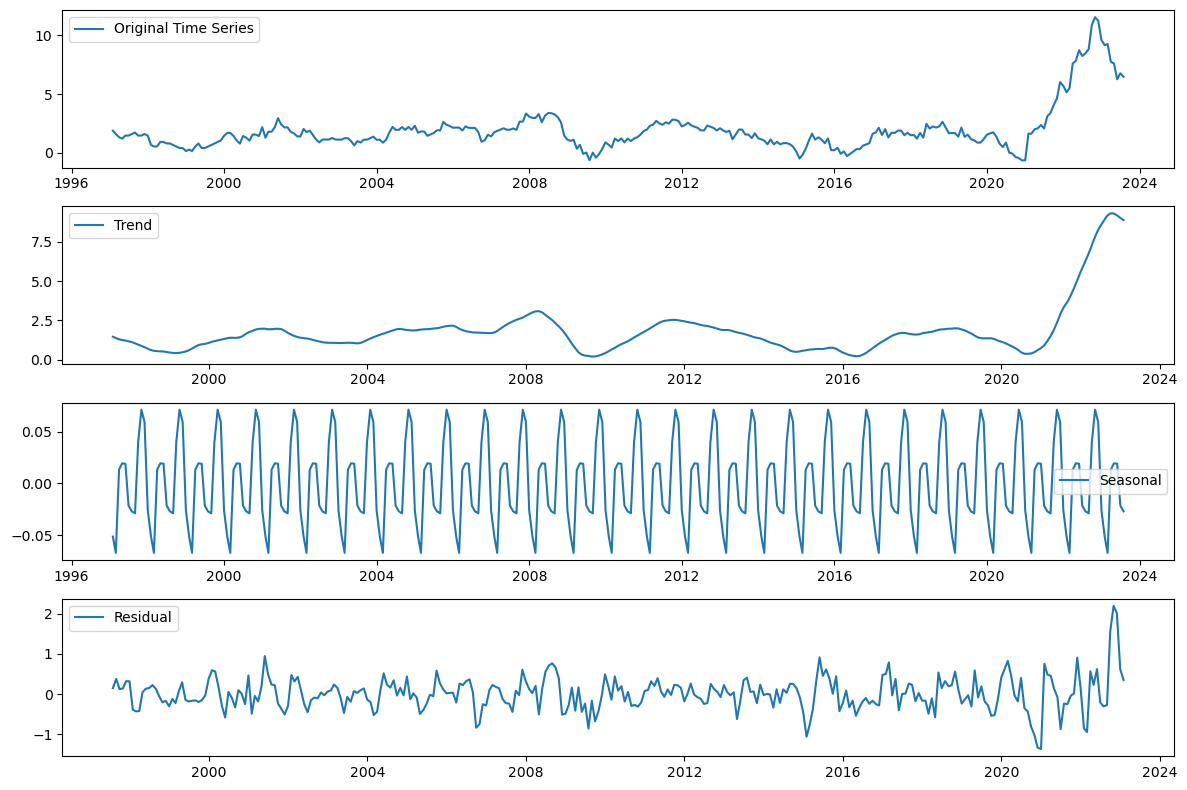

In [11]:
# Apply seasonal decomposition
result = seasonal_decompose(head_inf, model='additive')


# Plot the original time series
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(head_inf, label='Original Time Series')
plt.legend()

# Plot the trend component
plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend()

# Plot the seasonal component
plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend()

# Plot the residual component
plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()


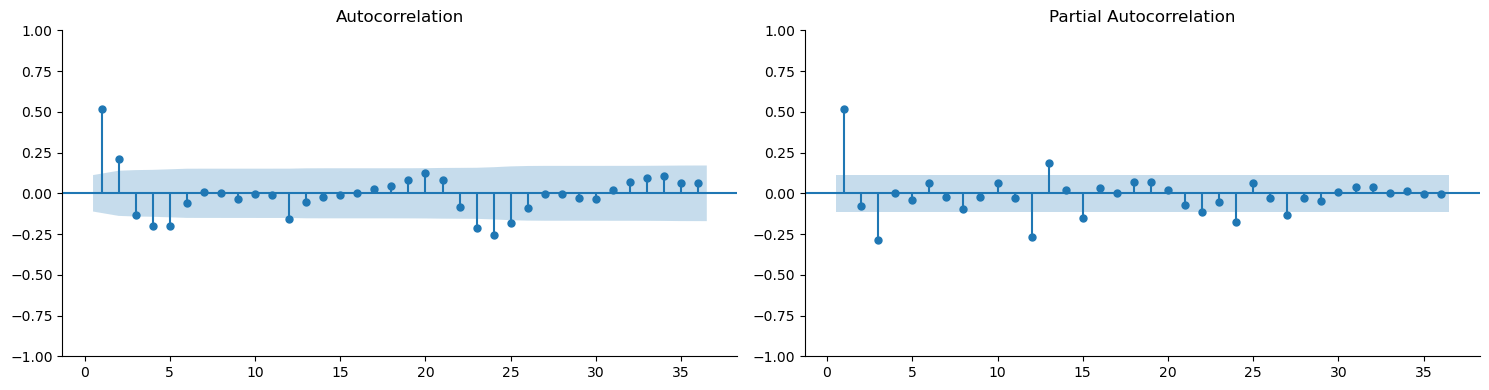

In [12]:
mine_g.plots_acf_pacf(result.resid[result.resid.notna()], lags=36);

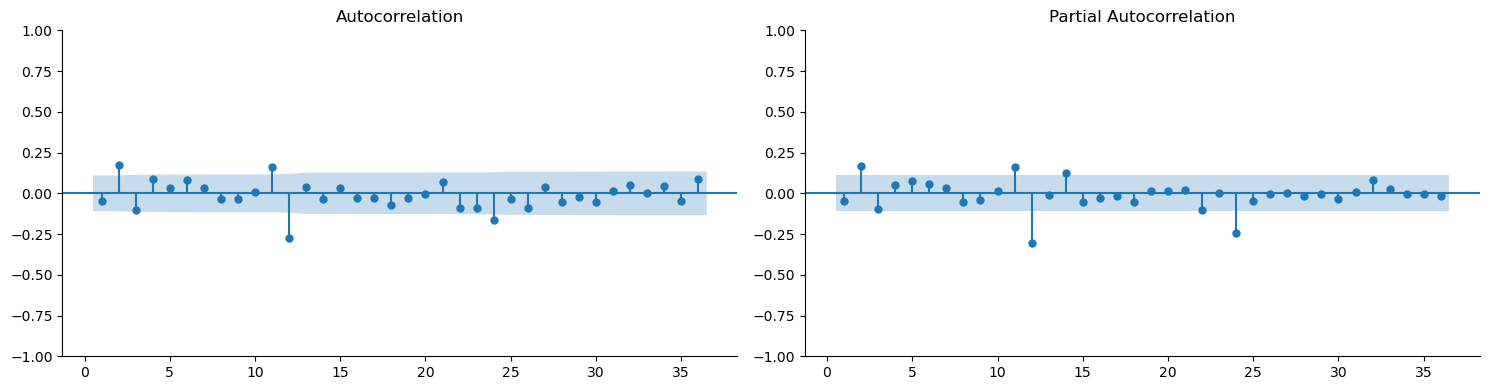

In [13]:
# try with differencing 1:

head_inf_year_diff = head_inf.diff(1)
mine_g.plots_acf_pacf(head_inf_year_diff.dropna(), lags=36)

In [14]:
head_inf_train = head_inf[head_inf.index <= '2015-12-31']
head_inf_test = head_inf[(head_inf.index > '2015-12-31') & (head_inf.index < '2023-01-01')]

## Model:

Since AR(1, 1, 0) ACF and PACF plots look much better with way less significance in lag 1
 => Try with model AR(1) and ARMA(1, 0, 0).

### AR(1) OLS:

In [15]:
import statsmodels.api as sm

y_train = head_inf_train[1:].values
X_train = head_inf_train[:-1].values


X_train = sm.add_constant(X_train)

model = sm.OLS(y_train,X_train)
results = model.fit()
y_pred_train = results.predict(X_train)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     1062.
Date:                Mon, 15 Jul 2024   Prob (F-statistic):           3.69e-87
Time:                        17:52:05   Log-Likelihood:                -70.549
No. Observations:                 227   AIC:                             145.1
Df Residuals:                     225   BIC:                             151.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1213      0.047      2.582      0.010       0.029       0.214
x1             0.9132      0.028     32.585      0.000       0.858       0.968
==============================================================================
Omnibus:                        5.071   Durbin-Watson:                   2.184
Prob(Omnibus):                  0.079   Jarque-Bera (JB):                5.533
Skew:                          -0.209   Prob(JB):                       0.0629
Kurtosis:                       3.640   Cond. No.                         4.64
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Sanity check:
I build my own OLS calculation version:

We can see both methods have same results.

In [16]:
y_train = head_inf_train[1:]
X_train = head_inf_train[:-1]

X_with_intercept = np.column_stack((np.ones(len(X_train)), X_train))

beta_hat = np.linalg.inv(X_with_intercept.T.dot(X_with_intercept)).dot(X_with_intercept.T).dot(y_train)
beta_hat

array([0.12133756, 0.91316746])

-----

Do recursive forecast: y_pred_h1 is used as input to forecast y_pred_h2 since ols can forecast 1 horizon at a time.

In [43]:

X_test_h_1 = head_inf[(head_inf.index >= '2015-10-31') & (head_inf.index < '2023-01-01')]
X_test_h_1 = sm.add_constant(X_test_h_1) # add constant

# forecast h1:
y_pred_test_h_1 = results.predict(X_test_h_1)
h1 = y_pred_test_h_1.reset_index(drop=True)[2:-1]

# use h1 to forecast h2:
X_test_h_2 = sm.add_constant(y_pred_test_h_1)
y_pred_test_h_2 = results.predict(X_test_h_2)
h2 = y_pred_test_h_2.reset_index(drop=True)[1:-2]

# use h2 to forecast h3
X_test_h_3 = sm.add_constant(y_pred_test_h_2)
y_pred_test_h_3 = results.predict(X_test_h_3)
h3 = y_pred_test_h_3.reset_index(drop=True)[:-3]

y_pred = pd.DataFrame({
    'ar_ols_h_1': h1.values,
    'ar_ols_h_2': h2.values,
    'ar_ols_h_3': h3.values
})
y_pred.columns = [f'ols_h_{i}' for i in [1, 2, 3]]


In [44]:
y_pred

,ols_h_1,ols_h_2,ols_h_3
0,0.305073,0.400090,1.253522
1,0.493679,0.399921,0.486686
2,0.029098,0.572149,0.486532
3,0.212929,0.147909,0.643806
4,-0.152066,0.315777,0.256404
...,...,...,...
79,7.862867,7.111033,6.988278
80,8.188482,7.301452,6.614902
81,10.074116,7.598793,6.788786
82,10.680094,9.320693,7.060308


In [45]:
mine_g.save_forecast(y_pred, cat_file_path= 'data/headline_forecast/head_infl_forecast.csv')

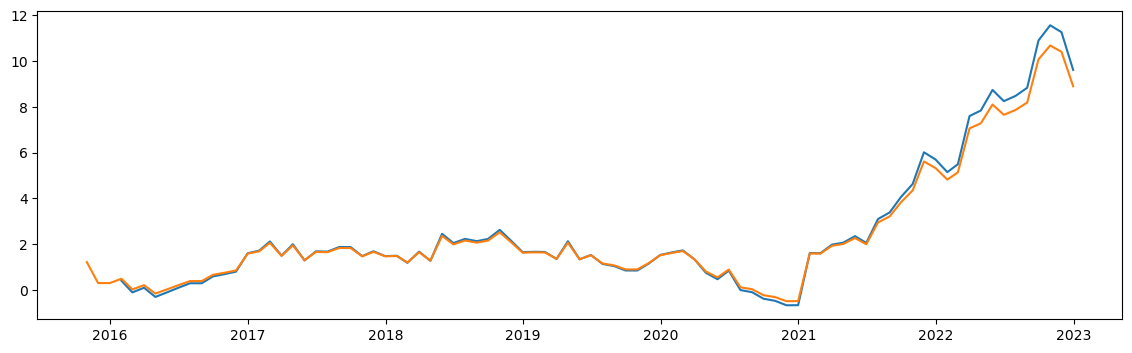

In [17]:
plt.figure(figsize=(14, 4))
plt.plot(head_inf_test)
plt.plot(y_pred_test_h_1)
plt.show()

### Model 2:
Model AR(1, 1, 0): 

In [46]:
order1 = (1, 1, 0)
seasonal_order1 = (0, 0, 0, 0)

base_1 = ARIMA(head_inf_train, 
                order=order1,
                seasonal_order=seasonal_order1,
                trend ='n').fit()
base_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               yoy_rate   No. Observations:                  228
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -72.968
Date:                Mon, 15 Jul 2024   AIC                            149.935
Time:                        18:15:41   BIC                            156.785
Sample:                    01-31-1997   HQIC                           152.699
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1441      0.059     -2.424      0.015      -0.261      -0.028
sigma2         0.1113      0.009     12.182      0.000       0.093       0.129
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 4.91
Prob(Q):                              0.82   Prob(JB):                         0.09
Heteroskedasticity (H):               1.20   Skew:                            -0.14
Prob(H) (two-sided):                  0.43   Kurtosis:                         3.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

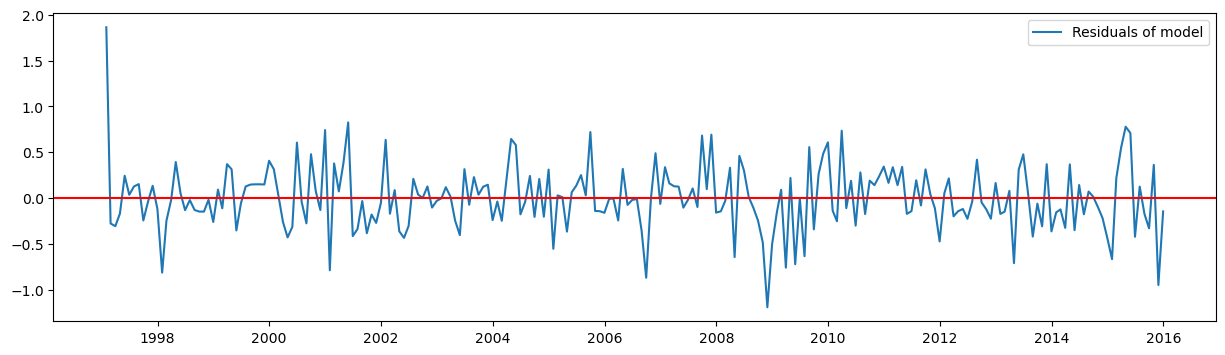

In [47]:
plt.figure(figsize=(15, 4))
plt.plot(base_1.resid, label = 'Residuals of model')
plt.axhline(base_1.resid.mean(), color = 'r')
plt.legend()
plt.show()

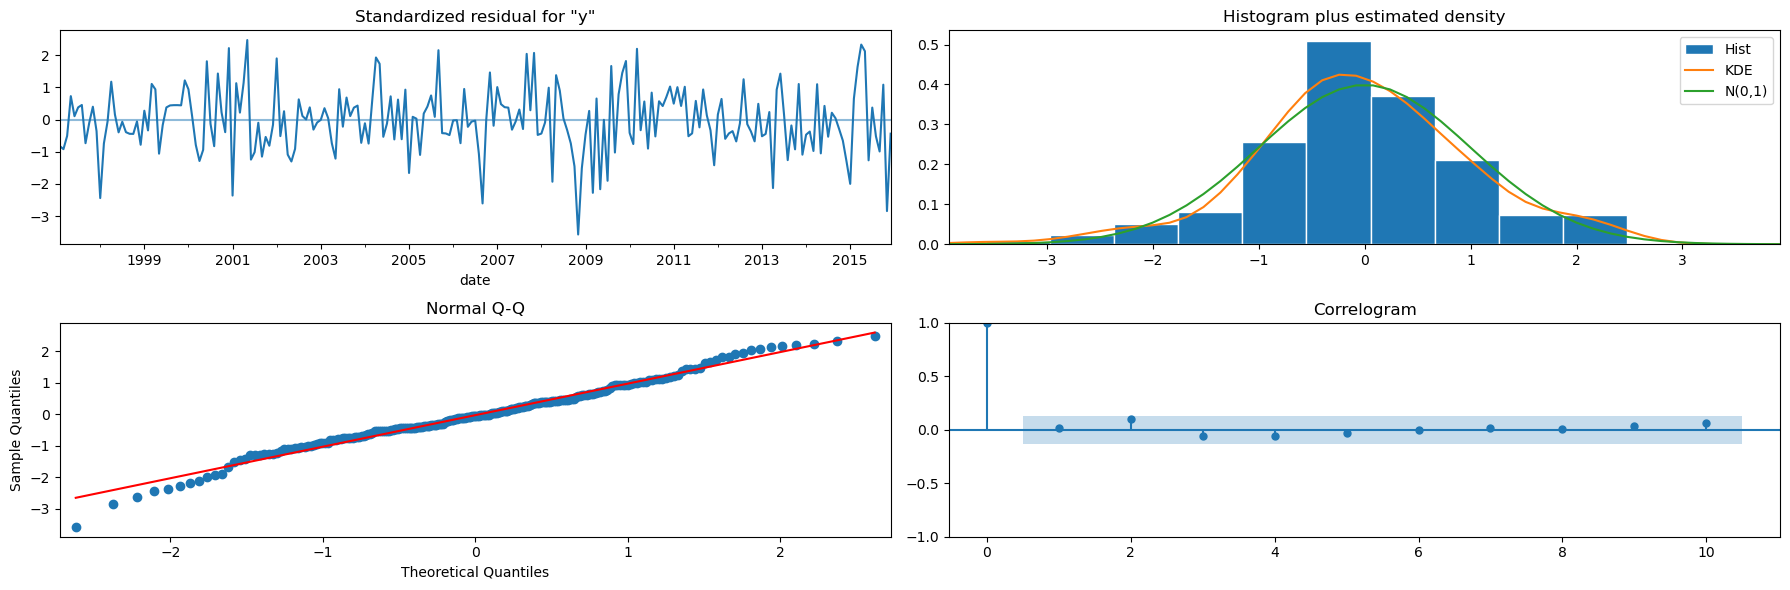

In [48]:
base_1.plot_diagnostics(figsize= (18, 6))
plt.tight_layout()
plt.show()

The residuals is not far from Normal distribution. AR(1, 1, 0) did a good job extracting most of the correlation.

In [55]:
horizons = [1, 2, 3] # horizon

forecast_df1 = mine_s.sarimax_recursive_forecast(head_inf, order=order1, seasonal_order= seasonal_order1, horizons=horizons, N = len(head_inf_train), T = len(head_inf_test))

Horizon 1, step 1
Prediction:  2016-01-31    0.201236
Freq: M, dtype: float64
Horizon 1, step 2
Prediction:  2016-02-29    0.377993
Freq: M, dtype: float64
Horizon 1, step 3
Prediction:  2016-03-31   -0.025772
Freq: M, dtype: float64
Horizon 1, step 4
Prediction:  2016-04-30    0.070035
Freq: M, dtype: float64
Horizon 1, step 5
Prediction:  2016-05-31   -0.238173
Freq: M, dtype: float64
Horizon 1, step 6
Prediction:  2016-06-30   -0.130462
Freq: M, dtype: float64
Horizon 1, step 7
Prediction:  2016-07-31    0.068961
Freq: M, dtype: float64
Horizon 1, step 8
Prediction:  2016-08-31    0.267289
Freq: M, dtype: float64
Horizon 1, step 9
Prediction:  2016-09-30    0.297574
Freq: M, dtype: float64
Horizon 1, step 10
Prediction:  2016-10-31    0.551627
Freq: M, dtype: float64
Horizon 1, step 11
Prediction:  2016-11-30    0.681614
Freq: M, dtype: float64
Horizon 1, step 12
Prediction:  2016-12-31    0.787967
Freq: M, dtype: float64
Horizon 1, step 13
Prediction:  2017-01-31    1.489123
Freq: 

In [56]:
forecast_df1

,ar_110_h_1,ar_110_h_2,ar_110_h_3
0,0.201236,0.329779,1.160298
1,0.377993,0.201232,0.333175
2,-0.025772,0.382279,0.201233
3,0.070035,-0.036898,0.381662
4,-0.238173,0.074585,-0.035253
...,...,...,...
79,8.453284,8.295415,8.659386
80,8.796783,8.455887,8.295984
81,10.712508,8.800719,8.455609
82,11.523992,10.729384,8.800305


In [57]:

mine_g.save_forecast(forecast_df1, cat_file_path= 'data/headline_forecast/head_infl_forecast.csv')

------